# Photometry

On this page we'll detect sources and perform photometry (along other measurements) for each pre-reduced image.
The procedure could also be applied to coadded images.

As before, could copy or write the code shown below in a script, or alternatively directly download this page as a {download}`jupyter notebook <./photometry.ipynb>` file.

To run the code, you'll need the module `dataredconfig.py`, as explained [here](./data.md).

TODO: 
* Do we need PSF homogeneization?

In [1]:
import dataredconfig

from pathlib import Path

import numpy as np
import astropy
import astropy.visualization
from astropy import units as u

%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt

import ccdproc
import photutils

In [2]:
# Locating the pre-reduced science images:
light_prered_dir = dataredconfig.work_dir / "LIGHT_PRERED"
science_files = ccdproc.ImageFileCollection(light_prered_dir, keywords=dataredconfig.ifc_header_keywords)

science_files = science_files.filter(object="M 37")

# Overview of all available files:
science_files.summary

<Table masked=True length=9>
                                                       file                                                       ...
                                                      str113                                                      ...
----------------------------------------------------------------------------------------------------------------- ...
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.new.fits ...
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-05-37_r_-10.00_60.00s_0001.new.fits ...
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-06-39_r_-10.00_60.00s_0002.new.fits ...
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-07-43_g_-10.00_60.00s_0000.new.fits ...
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-08-45_g_-10.00_60.00s_0001.new.fits ...
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-09-47_g_-10.00_60.00s_0002.new.fits ...
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-10-51_i_-10.00_60.00s_0000.new.fits ...
 /Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-11-53_i_-9.90_60.00s_0001.new.fits ...
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-12-55_i_-10.00_60.00s_0002.new.fits ...

We will measure photometry on all these files.
But we start by picking one reference image, used to detect sources and to check the overall procedure. 

In [3]:
ref_image = ccdproc.CCDData.read(science_files.files[-1])

## Estimating and subtracting the background

In [4]:

def estimate_background(image):
    """
    image: CCDData object
    """
    #data = img.data + 0.0

    bkg = photutils.background.Background2D(
        image.data,
        box_size=(500, 500),
        filter_size=(3, 3),
        bkg_estimator=photutils.background.MedianBackground())
    
    return bkg.background, bkg.background_rms # Both are numpy arrays

background, background_rms = estimate_background(ref_image)

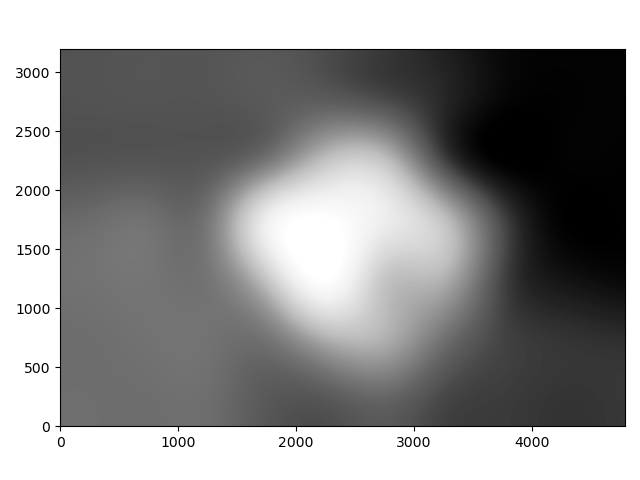

In [5]:
# Visualize the background image:
plt.figure()
plt.imshow(background, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.tight_layout()
plt.show()

In [6]:
# We subtract the background
ref_image_noback = ref_image.subtract(ccdproc.CCDData(background, unit="adu"))
threshold = 3.0 * background_rms # this is an array


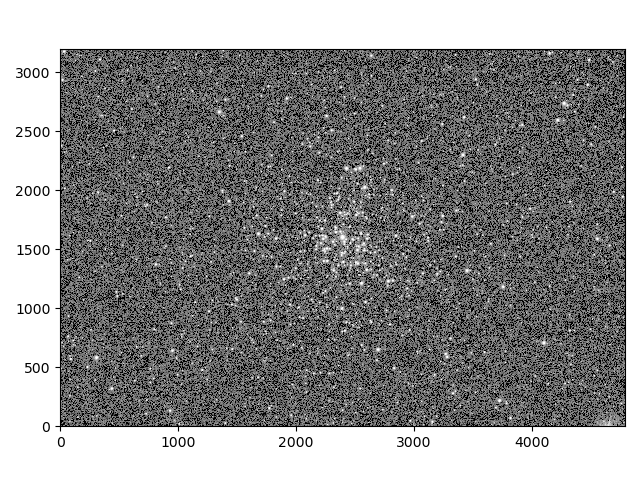

In [7]:

plt.figure()
plt.imshow(ref_image_noback.data, origin='lower', cmap='Greys_r', interpolation='nearest',
           norm=astropy.visualization.simple_norm(ref_image_noback.data, stretch="log", min_cut=-20, max_cut=2000))
plt.tight_layout()
plt.show()

In [8]:
def detect_and_measure(image):
    """
    """
    data = image.data 

    # Filtering (convolving with a 2D Gaussian) for source detection
    kernel = photutils.segmentation.make_2dgaussian_kernel(fwhm=4.0, size=21)  # FWHM in pixels
    convolved_data = astropy.convolution.convolve(data, kernel)

    # Segmenting the image
    finder = photutils.segmentation.SourceFinder(npixels=4, connectivity=4, progress_bar=False)
    segment_map = finder(convolved_data, threshold)
    #segment_map = finder(data, threshold)

    # And measuring sources
    source_catalog = photutils.segmentation.SourceCatalog(data, segment_map, convolved_data=convolved_data, wcs=image.wcs)
    source_table = source_catalog.to_table(
        columns=["xcentroid_win", "ycentroid_win", "sky_centroid_win",
                 "fwhm", "max_value", "kron_flux", "segment_flux", "segment_area"]
        )

    return source_table

In [9]:
# Run this on the reference image
ref_catalog = detect_and_measure(ref_image_noback)

In [10]:
ref_catalog = ref_catalog[ref_catalog["kron_flux"] > 50000] # To pick the brightest sources, for testing
len(ref_catalog)

833

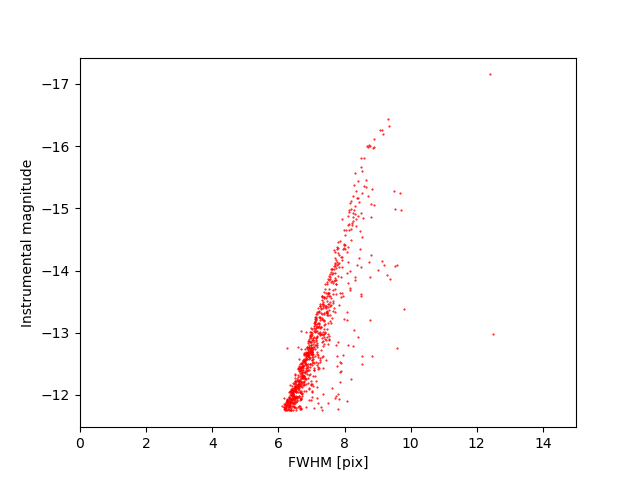

In [11]:
# Plotting mag and size

ref_catalog["mag"] = -2.5 * np.log10(ref_catalog["kron_flux"].value)

plt.figure()
plt.plot(ref_catalog["fwhm"].value, ref_catalog["mag"], "r.", markersize=1)
plt.xlim(0, 15)
plt.gca().invert_yaxis()
plt.xlabel("FWHM [pix]")
plt.ylabel("Instrumental magnitude")
plt.show()

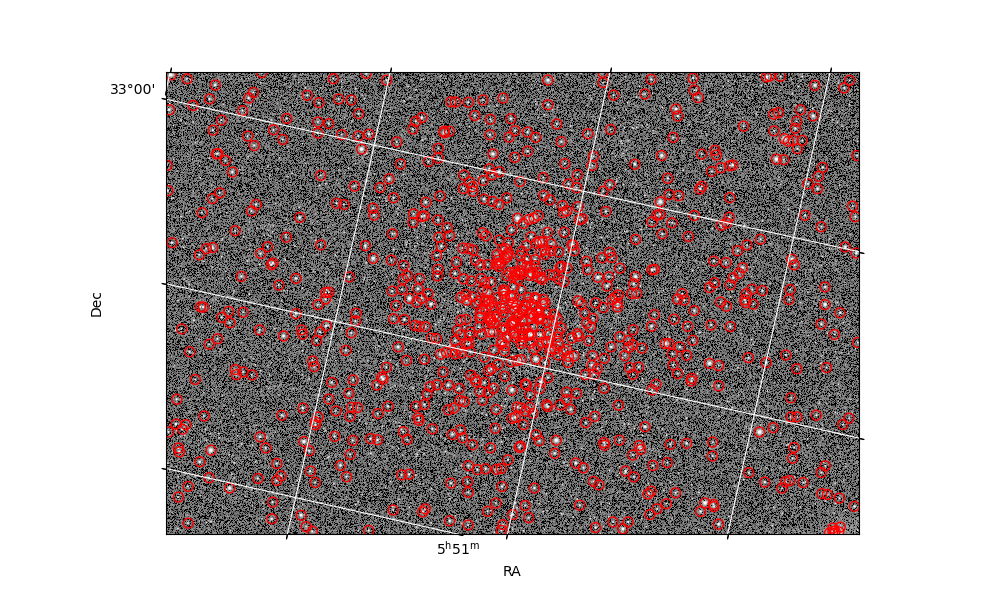

In [12]:
# After running a detection, it's almost mandatory to check the result with a visualization

plt.figure(figsize=(10, 6))
ax = plt.subplot(projection=ref_image_noback.wcs)
ax.imshow(ref_image_noback.data, origin='lower', cmap='Greys_r', interpolation='nearest',
    norm=astropy.visualization.simple_norm(ref_image_noback.data, stretch="log", min_cut=-20, max_cut=2000))
ax.scatter(
    ref_catalog["xcentroid_win"],
    ref_catalog["ycentroid_win"],
    transform=ax.get_transform('pixel'),
    s=50,
    edgecolor='red', facecolor='none'
    )
ax.grid(color='white', ls='solid')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.show()



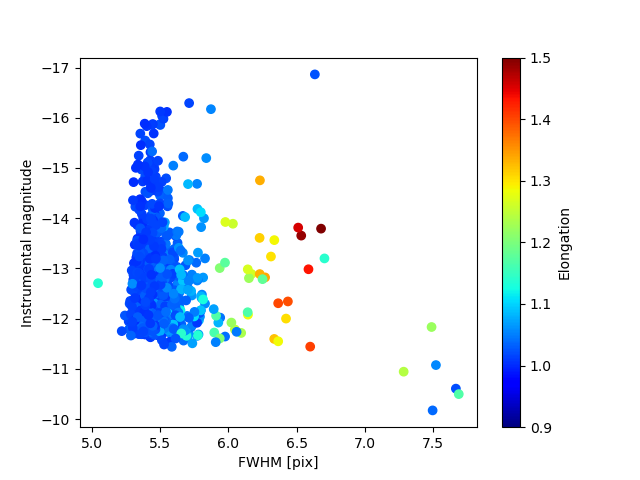

In [13]:
# Check plot of photometric catalog
apertures = photutils.aperture.SkyCircularAperture(ref_catalog["sky_centroid_win"], r=4*u.arcsec)

aperture_measurements = photutils.aperture.ApertureStats(ref_image_noback.data, aperture=apertures, wcs=ref_image_noback.wcs)
aperture_catalog = aperture_measurements.to_table(columns=["fwhm", "elongation", "sum"])

aperture_catalog["mag"] = -2.5 * np.log10(aperture_catalog["sum"].value)

plt.figure()
plt.scatter(
    aperture_catalog["fwhm"].value, 
    aperture_catalog["mag"], 
    c=aperture_catalog["elongation"].value,
    vmin=0.9, vmax=1.5,
    cmap="jet"
)
plt.gca().invert_yaxis()
plt.colorbar(label="Elongation")
plt.xlabel("FWHM [pix]")
plt.ylabel("Instrumental magnitude")
plt.show()

In [15]:
# We group all steps of the photometric measurement into one function: 
def measure_photometry(image, sky_positions):
    """
    """
    background, background_rms = estimate_background(image)
    image_noback = image.subtract(ccdproc.CCDData(background, unit="adu"))
    
    aperture_radii = [4, 6, 8] # In arcsec

    # For each radius, we now generate a separate catalog, and combine those afterwards
    aperture_catalogs = []
    for r in aperture_radii:

        apertures = photutils.aperture.SkyCircularAperture(sky_positions, r=r*u.arcsec)
        aperture_measurements = photutils.aperture.ApertureStats(image.data, aperture=apertures, wcs=image.wcs)
        aperture_catalog = aperture_measurements.to_table(columns=["fwhm", "elongation", "sum"])

        # Rename columns by adding the aperture radius, to get for example "sum_4" instead of sum
        for name in aperture_catalog.colnames:
            aperture_catalog.rename_column(name, new_name=f"{name}_{str(r)}")
        
        aperture_catalogs.append(aperture_catalog)
    
    # And now merge these catalogs into a single one:
    merged_catalog = astropy.table.hstack(aperture_catalogs,
        join_type="exact", metadata_conflicts="silent"
        )
    return merged_catalog


In [16]:

# As a test, run this on the ref_image:
photocat = measure_photometry(ref_image, ref_catalog["sky_centroid_win"])
print(photocat.colnames)
print(photocat)

['fwhm_4', 'elongation_4', 'sum_4', 'fwhm_6', 'elongation_6', 'sum_6', 'fwhm_8', 'elongation_8', 'sum_8']
      fwhm_4          elongation_4    ...    elongation_8          sum_8       
       pix                            ...                                      
------------------ ------------------ ... ------------------ ------------------
6.0481651180147376 1.0556413722579754 ... 1.0178708923781643  217208.6670536905
 5.973089205902765 1.0377993156474419 ... 1.0096412831700012 222377.04577428155
  6.21801816285812 1.0227024901157409 ...  1.006846213793943 127180.17052760639
  6.21907248083885 1.0246781545421202 ...  1.003196633001574  161058.5025293353
 5.769338931635437  1.033152863935024 ... 1.0349423670124507  321539.7216892893
 6.343452460304226 1.0396749733916817 ... 1.0055684692269493  117909.8988183084
 6.083699006174107  1.014796762300841 ... 1.0022025770589085 126973.18012934508
 5.577309418979586 1.0152225582831274 ...  1.016629823633307   797965.341337336
  6.1103676645

We can now apply this measurement function to all images of the object

In [20]:
# Where to write the catalogs:
photometry_dir = dataredconfig.work_dir / "PHOTOMETRY"
photometry_dir.mkdir(exist_ok=True)

for science_file in science_files.files:

    image_filename = Path(science_file).stem
    print(f"Running on {image_filename}...")

    image = ccdproc.CCDData.read(science_file)

    # We now build a dict containing some meta-information of the image taken from the FITS header.
    # We'll later write this as meta-information of the catalogue.
    meta_from_image = {key: image.header[key] for key in [
        "DATE-OBS", "EXPTIME", "IMAGETYP", "AIRMASS", "PIERSIDE", "FILTER", "OBJECT",
        "FOCUSPOS", "FOCTEMP", "RA", "DEC", "SET-TEMP", "CCD-TEMP", "GAIN", "OFFSET"
        ]}
    
    # Now run the measurements:
    catalog = measure_photometry(image, ref_catalog["sky_centroid_win"])

    # Add the information from the FITS header
    catalog.meta.update(meta_from_image)

    # And write all this as a FITS table
    catalog.write(photometry_dir / f"{image_filename}.fits", overwrite=True)
    

Running on 2024-03-08_22-04-34_r_-10.00_60.00s_0000.new...


Running on 2024-03-08_22-05-37_r_-10.00_60.00s_0001.new...


Running on 2024-03-08_22-06-39_r_-10.00_60.00s_0002.new...


Running on 2024-03-08_22-07-43_g_-10.00_60.00s_0000.new...


Running on 2024-03-08_22-08-45_g_-10.00_60.00s_0001.new...


Running on 2024-03-08_22-09-47_g_-10.00_60.00s_0002.new...


Running on 2024-03-08_22-10-51_i_-10.00_60.00s_0000.new...


Running on 2024-03-08_22-11-53_i_-9.90_60.00s_0001.new...


Running on 2024-03-08_22-12-55_i_-10.00_60.00s_0002.new...


In [28]:


filter_names = ("g", "r", "i")
filter_catalogs = []

for filter_name in filter_names:
    print(f"Starting filter {filter_name}")
    this_filter_catalogs = []
    for science_file in science_files.files_filtered(filter=filter_name):
        print(f"Running on {science_file}...")
        image = ccdproc.CCDData.read(science_file)
        catalog = measure_photometry(image, ref_catalog["sky_centroid_win"])
        this_filter_catalogs.append(catalog)
    this_filter_catalog = astropy.table.dstack(this_filter_catalogs, join_type="exact", metadata_conflicts="silent")
    # Rename columns by adding the filter_name:
    for name in this_filter_catalog.colnames:
        this_filter_catalog.rename_column(name, new_name=f"{name}_{str(filter_name)}")
    print(this_filter_catalog.colnames)
    filter_catalogs.append(this_filter_catalog)


merged_catalog = astropy.table.hstack(filter_catalogs,
        join_type="exact", metadata_conflicts="silent"
        )

Starting filter g
Running on /Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-07-43_g_-10.00_60.00s_0000.new.fits...
Running on /Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-08-45_g_-10.00_60.00s_0001.new.fits...
Running on /Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-09-47_g_-10.00_60.00s_0002.new.fits...
['fwhm_4', 'elongation_4', 'sum_4', 'fwhm_6', 'elongation_6', 'sum_6', 'fwhm_8', 'elongation_8', 'sum_8']
Starting filter r
Running on /Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.new.fits...
Running on /Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-05-37_r_-10.00_60.00s_0001.new.fits...
Running on /Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-06-39_r_-10.00_60.00s_0002.new.fits...
['fwhm_4', 'elongation_4', 'sum_4', 'fwhm_6', 'elongation_6', 'sum_6', 'fwhm_8', 'elongati

In [26]:

merged_catalog
    

<QTable length=833>
                fwhm_4_1                ...
                  pix                   ...
               float64[3]               ...
--------------------------------------- ...
 6.478688290785176 .. 6.475901140281841 ...
 6.471123452704175 .. 6.435253407068672 ...
   6.9444416409694 .. 7.015111500723572 ...
 6.685945116600584 .. 6.692398038704313 ...
 6.301139926347663 .. 6.252813712184074 ...
7.281818262355632 .. 7.4137541892703105 ...
 6.977146595326397 .. 6.909381078433726 ...
  6.30942514363979 .. 6.232400491762201 ...
7.189061907805131 .. 7.1044901607808715 ...
                                    ... ...
 6.785516072000248 .. 6.777874398650715 ...
 6.221903660671955 .. 6.205781324209806 ...
  7.38963255367473 .. 7.297135331364063 ...
6.814471974486692 .. 6.9003038327751165 ...
6.1706803264921435 .. 6.251074128246929 ...
  7.527851794031627 .. 7.53297060219585 ...
 6.454755257528269 .. 6.457626517931399 ...
  6.480832794877027 .. 6.50487328290095 ...
 7.096532921520797 .. 7.118368648205716 ...
 7.006875226122825 .. 6.913722867858934 ...